# 2. SHO Fitting in Pytorch


In [1]:
import sys
sys.path.append('../../')
sys.path.append('C:\codes\m3_learning\m3_learning\src')

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads Data


In [3]:
# Specify the filename and the path to save the file
filename = 'data_raw_unmod.h5'
save_path = "./Data"


data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, resample_bins=None, SHO_fit_func_NN=SHO_fit_func_nn,
                     )

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Raw_Data-SHO_Fit_000
  --------------------
  ├ Fit
  ├ Guess
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
  ├ completed_fit_positions
  ├ completed_guess_positions
Datasets and

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model.

Note: This uses the results from the least squares fitting LSQF results.


In [4]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 0), (-np.pi, np.pi)],
             image_scalebar=image_scalebar)

{'resampled': False, 'label': 'Raw', 'noise': 0, 'measurement_state': 'all'}
True 


    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = None
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
predicted 


    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = None
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
./Figures/Figure_7_PyTorch_fit_tester.png
./Figures/Figure_7_PyTorch_fit_tester.svg


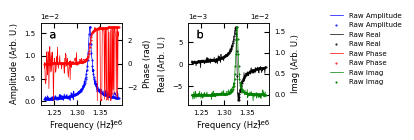

In [5]:
true = {"resampled": False,
        "label": "Raw",
        "noise": 0, 
        "measurement_state": "all"}

predicted = {"fitter": "LSQF", "resampled": False, "label": "Raw", "scaled": False, "noise" : 0}

BE_viz.fit_tester(true, predicted, filename="Figure_7_PyTorch_fit_tester")

**Figure 7** Shows the result of the PyTorch function. The result based on the LSQF results shows that the PyTorch function is implemented correctly.


## Pytorch Model

### Model Architecture


### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

#### Visualizing the Scaled Data



    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = None
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
./Figures/Figure_8_Scaled Raw Data.png
./Figures/Figure_8_Scaled Raw Data.svg


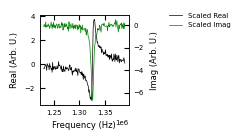

In [6]:
state = {"fitter": "LSQF", "resampled": True, "scaled": True, "label": "Scaled"}

BE_viz.nn_checker(state, filename="Figure_8_Scaled Raw Data")

**Figure 8** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum.



    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
./Figures/Figure_9_Phase_Shifted_Scaled_Histograms.png
./Figures/Figure_9_Phase_Shifted_Scaled_Histograms.svg


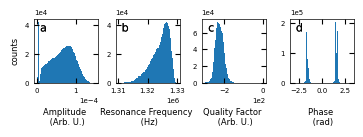

In [7]:
dataset.LSQF_phase_shift = np.pi / 2

BE_viz.SHO_hist(
    dataset.SHO_fit_results(), filename="Figure_9_Phase_Shifted_Scaled_Histograms"
)

**Figure 9** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.


### Training the Model

We will train the model from scratch. Generally the model trains very well in a few epochs. This will take less than 5 minutes to train on a GPU.


In [8]:
random_seed(seed=42)

# instantiate the model
model = SHO_Model(dataset, training=True, model_basename="SHO_Fitter_original_data")

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3050 Ti Laptop GPU

    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
None


In [9]:
train = True

if train:
    # fits the model
    model.fit(
        dataset.X_train,
        500,
        optimizer="Adam",
        epochs = 5,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


c:\Users\jca92\.conda\envs\tutorials\lib\site-packages\torch\autograd\__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam
epoch : 1/5, recon loss = 0.06375627
--- 42.44072866439819 seconds ---
Adam
epoch : 2/5, recon loss = 0.03509607
--- 44.1688597202301 seconds ---
Adam
epoch : 3/5, recon loss = 0.03455219
--- 52.961753368377686 seconds ---
Adam
epoch : 4/5, recon loss = 0.03436440
--- 66.68784475326538 seconds ---
Adam
epoch : 5/5, recon loss = 0.03420747
--- 84.20286059379578 seconds ---


### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by comparing the different stages of the autoencoder including the raw data, the generated curves.


./Figures/Figure_10_NN_validation_Train.png
./Figures/Figure_10_NN_validation_Train.svg


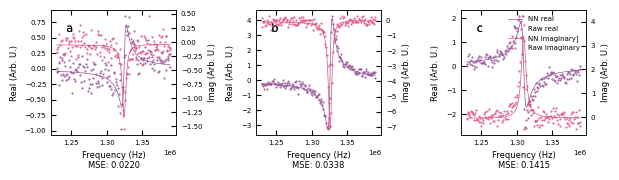

In [10]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

**Figure 10** Raw data and reconstruction of the autoendcoder for the training data. Shows the a) best, b) median, and c) worst reconstruction of the training data.


./Figures/Figure_11_NN_validation_test.png
./Figures/Figure_11_NN_validation_test.svg


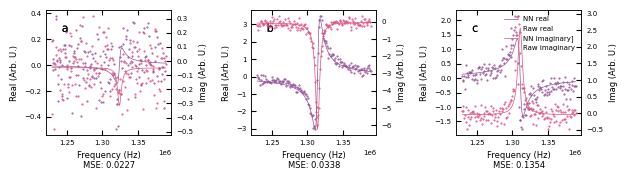

In [11]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_11_NN_validation_test",
)

**Figure 11** Raw data and reconstruction of the autoendcoder for the test data. Shows the a) best, b) median, and c) worst reconstruction of the test data.



    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
None
./Figures/Figure_12_NN_validation_full_data.png
./Figures/Figure_12_NN_validation_full_data.svg


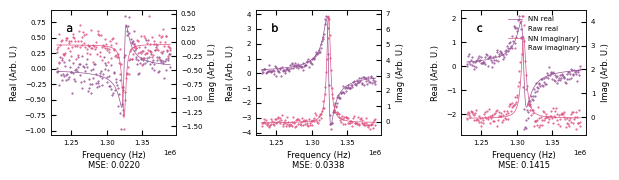

In [13]:
state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": False,
    "scaled": True,
    "output_shape": "index",
}

X_data, Y_data = dataset.NN_data()

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    state,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_12_NN_validation_full_data",
)

**Figure 12** Raw data and reconstruction of the autoendcoder for the entire data. Shows the a) best, b) median, and c) worst reconstruction of the entire data.


### Calculate the MSE error

We can calculate the MSE error for the training, test, and entire data set.


In [14]:
X_data, Y_data = dataset.NN_data()
LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': True,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': 0}

data = (LSQF_, X_data, X_test, X_train)
labels = ["LSQF", "Full Data", "Test Data", "Train Data"]

model.print_mse(data, labels)


    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
None

    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
None
LSQF Mean Squared Error: 0.0345
Full Data Mean Squared Error: 0.0340
Test Data Mean Squared Error: 0.0340
Train Data Mean Squared Error: 0.0340


From here on out we will assume that the autoencoder is working correctly, and is not overfit. This is a good assumption because the results are more or less the same for the training, test, and entire data set.

We note that the LSQF has a somewhat lower MSE, this does not necessarily mean that it is doing a better job fitting. 
1. The quality of the MSE is not an indicator of how good the parameters are fit, just an indicator of how good the reconstruction is.
2. There could be some aliasing in the LSQF results, which would result in a lower MSE.


### GPU Inference Speedtest

Here we show the speedtest for the GPU. This is done using the torch.cuda.synchronize() function. This is used to ensure that the GPU is done processing before the timer is stopped.


In [15]:
X_data, Y_data = dataset.NN_data()

model.inference_timer(X_data, batch_size=1000)


    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
    loop interpolated = False
                  
None
Mean execution time computed for 1383 batches of size 1000
Average execution time per batch (ms): 15.024900 ± 4.229493
Average execution time per iteration (ms): 0.015025 ± 0.004229
Total execution time (s): 20.78 


### Histogram of Fit Results

It is useful to view the histogram of the fitting results to apply any necessary phase shifts, and to see if the results are reasonable.



    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
./Figures/Figure_13_NN_Unscaled_Parameters_Histograms.png
./Figures/Figure_13_NN_Unscaled_Parameters_Histograms.svg


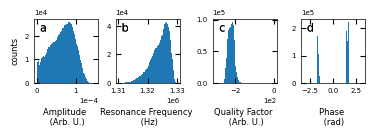

In [16]:
# we will add the appropriate phase shift to the dataset based on the fix seed,
# If your seed is different the results might vary
dataset.NN_phase_shift = np.pi/2 

# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_hist(parm, filename="Figure_13_NN_Unscaled_Parameters_Histograms")

**Figure 13** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase.



    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
./Figures/Figure_13_NN_scaled_Parameters_Histograms.png
./Figures/Figure_13_NN_scaled_Parameters_Histograms.svg


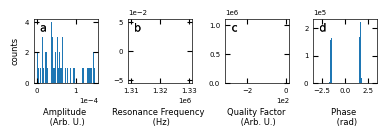

In [17]:
#TODO: need to fix this scaling issue
out = dataset.SHO_scaler.transform(parm)

BE_viz.SHO_hist(out, filename="Figure_13_NN_scaled_Parameters_Histograms")

**Figure 14** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase. The histograms show the scaled parameters.


./Figures/Figure_15_NN_Switching_Maps.png
./Figures/Figure_15_NN_Switching_Maps.svg


C:\codes\m3_learning\m3_learning\src\m3_learning\be\viz.py:1371: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


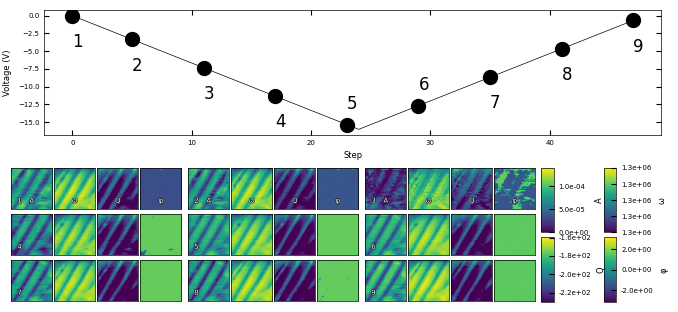

In [18]:
# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_switching_maps(parm, filename="Figure_15_NN_Switching_Maps")

## SHO Fitting Movies

In [21]:
BE_viz.SHO_fit_movie_images(noise = 0, 
                            models = [model],
                            scalebar_= True, 
                            basepath = "Movies/SHO_NN_",  
                            filename="SHO_NN",
                            phase_shift = [np.pi/2],)


    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = on
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None

    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = off
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0000.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0001.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0002.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0003.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0004.png
Movies/SHO_NN_Noise_0/SHO_N

## Comparison SHO and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.



    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None

    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None

    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.570796326794896

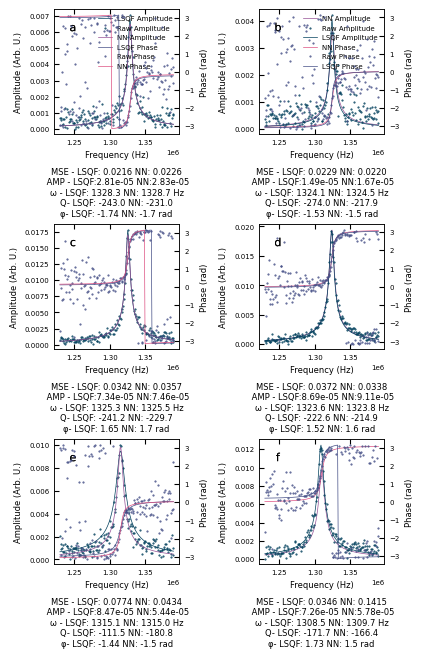

In [22]:
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2
dataset.measurement_state = "all"


true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}

out_state = {"scaled": True, "raw_format": "magnitude spectrum"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=model, out_state=out_state, SHO_results=True, n=n
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_14_LSQF_NN_bmw_comparison",
    # display_results = None
)

### Statistics of the Results for Training, Validation, and Entire Dataset


c:\Users\jca92\.conda\envs\tutorials\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jca92\.conda\envs\tutorials\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jca92\.conda\envs\tutorials\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jca92\.conda\envs\tutorials\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

./Figures/Figure_16_Violin.png
./Figures/Figure_16_Violin.svg


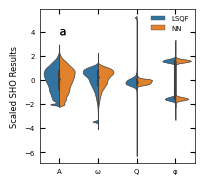

In [23]:
true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}


BE_viz.violin_plot_comparison(true_state, model, X_data, filename="Figure_16_Violin") 


### SHO Comparison Movie

In [25]:
BE_viz.SHO_fit_movie_images(noise = 0, 
                            models=[None, model], 
                            scalebar_= True, 
                            basepath = "Movies/SHO_NN_LSQF_Compare_",  
                            filename="SHO_NN_LSQF_Compare", 
                            labels = ['LSQF', 'NN'],
                            phase_shift = [np.pi/2, np.pi/2])


    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = on
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None

    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = off
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None
Movies/SHO_NN_LSQF_Compare_Noise_0/SHO_NN_LSQF_Compare_noise_0_0000.png
Movies/SHO_NN_LSQF_Compare_Noise_0/SHO_NN_LSQF_Compare_noise_0_0001.png
Movies/SHO_NN_LSQF_Compare_Noise_0/SHO_NN_LSQF_Compare_noise_0_0002.png
Movies/SHO_NN_LSQF_Compare_Noise_0/SHO_NN

### Outliers Visualization

Resonance outliers


    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None

    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 1.5707963267948966
    Noise Level = 0
    loop interpolated = False
                  
None

    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Pha

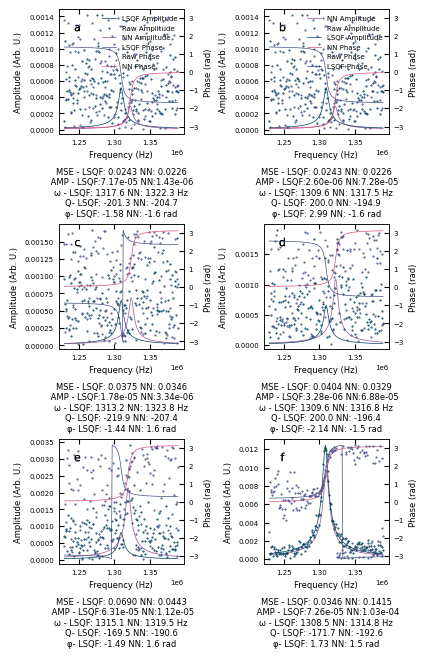

In [26]:

dataset.measurement_state = "all"
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2

true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}

# gets the parameters from the SHO LSQF fit
true = dataset.SHO_fit_results(state = true_state).reshape(-1, 4)

# finds the index less than a certain value
# we can add something a function to generalize this TODO
ind = np.argwhere(true[:,1]< -3).flatten()



true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all"
}

out_state = {"raw_format": "magnitude spectrum", "measurement_state": "all"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
    index = ind,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=model,
    out_state=out_state, SHO_results=True, n=n, index = ind
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_14_LSQF_NN_bmw_comparison",
    # display_results = None
)